# Use the GitHub API to visualize project contributions

In [1]:
import pandas
import requests
import matplotlib
import matplotlib.pyplot as plt
import seaborn

%matplotlib inline

In [2]:
def query(format_url, **kwargs):
    url = format_url.format(**kwargs)
    response = requests.get(url)
    obj = response.json()
    df = pandas.DataFrame(obj)
    return df

def concat_queries(format_url, kwargs_list):
    dfs = list()
    for kwargs in kwargs_list:
        df = query(format_url, **kwargs)
        for key, value in kwargs.items():
            df[key] = value
        dfs.append(df)
    return pandas.concat(dfs)

In [3]:
repo_df = query('https://api.github.com/orgs/cognoma/repos')
repo_df.name.tolist()

['cognoma',
 'core-service',
 'task-service',
 'cancer-data',
 'machine-learning',
 'sandbox',
 'frontend',
 'cognoma.github.io',
 'uiux']

In [4]:
format_url = 'https://api.github.com/repos/cognoma/{repo_name}/contributors'
kwargs_list = [{'repo_name': repo} for repo in repo_df.name]
contrib_df = concat_queries(format_url, kwargs_list)

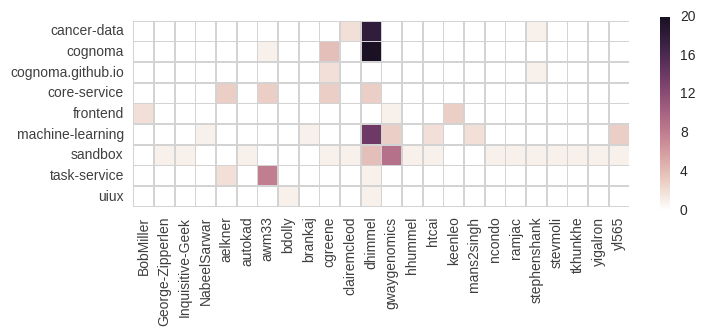

In [5]:
contrib_plot_df = (contrib_df
    #.query("repo_name != 'sandbox'")
    .pivot_table('contributions', 'repo_name', 'login', fill_value=0)
)
cmap = seaborn.cubehelix_palette(light=1, as_cmap=True, gamma=1.3)
ax = seaborn.heatmap(contrib_plot_df, square=True, linewidths=0.5, cmap=cmap, linecolor='#d3d3d3')
#ax.xaxis.set_ticks_position('top')
#ax.xaxis.set_label_position('top')
plt.xticks(rotation=90, color='#3f3f3f')
plt.yticks(color='#3f3f3f')
plt.ylabel('')
plt.xlabel('')
fig = ax.get_figure()
fig.set_size_inches(w=8, h=2.5)
fig.savefig('contribution-heatmap.png', dpi=200, bbox_inches='tight')
fig.savefig('contribution-heatmap.svg', bbox_inches='tight')